<img src="http://ec2-34-212-11-29.us-west-2.compute.amazonaws.com/InternalWiki/images/2/2e/CML_Logo.gif">

## Quick Start Tutorial for the Better Oscillation Detection Method
This tutorial provides a brief example for using CML's P_episode package for detecting true oscillations in electrophysiological data.
The method is adapted from Caplan Et Al (2001), *Distinct Patterns of Brain Oscillations Underlie Two Basic Parameters of Human Maze Learning*

In [1]:
import sys
sys.path.append('/home1/jrudoler/src/cmlcode/BOSC/') 
import numpy as np
import pandas as pd
import cmlreaders as cml
import P_episode as pep
import scipy.stats as scp
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from ptsa.data.filters import ButterworthFilter
import warnings
warnings.simplefilter('ignore')

/home1/jrudoler/anaconda3/envs/cml37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


Pick a subject, create a CMLReader object, and use it to load events and electrode configurations

In [2]:
subject = 'R1195E'
method = 'bip'
reader = cml.CMLReader(subject = subject, experiment = 'FR1', session = 0)
pairs = reader.load("pairs")
all_events = reader.load('task_events')

Use events and electrodes to load EEG (in this case, bipolar) for a single electrode pair.

In [3]:
bip = reader.load_eeg(scheme = pairs[pairs.label =='5LD3-5LD4']).to_ptsa().mean(['event', 'channel'])
bip = ButterworthFilter(bip, freq_range=[58., 62.], filt_type='stop', order=4).filter()

In [4]:
pep.P_episode?

Init signature: pep.P_episode(events, eeg, event_type='WORD', relstart=300, relstop=1301, width=5, sr=None, lowfreq=2, highfreq=120, numfreqs=30, percentthresh=0.95, numcyclesthresh=3)
Docstring:     
An object for handling the Better Oscillation Detection Methods

Parameters:
    events - a pandas DataFrame containing the event or events (from the same session) being analyzed
    eeg - a ptsa timeseries object containing EEG data. Should contain data for ONE ELECTRODE ONLY, 
                    and therefore should not have a "channel" dimension. Should contain contiguous EEG for an entire session

    event_type - 'WORD' for encoding, 'REC_WORD' for retrieval.

    relstart = beginning of event in ms relative to word onset
    relstop = end of event in ms relative to word onset

    width - the length of the MorletWaveletFilter
    sr - the sample rate for the EEG signal. If none, it uses CMLReader to find it 
    lowfreq - the lowest frequency to be calculated
    highfreq - the hig

Initialize a P_episode class object, which will automatically perform wavelet decomposition. 

In [7]:
bosc = pep.P_episode(all_events, bip, event_type='REC_WORD', relstart = 300, relstop = 1301, width=5, sr=bip.samplerate.values, 
                     lowfreq=2, highfreq=120, numfreqs=30, percentthresh=.95, numcyclesthresh=3)

CPP total time wavelet loop:  4.4527857303619385


Visualize the background fit with built in method background_fit(). The plot_type parameter allows you to either specify a list index to plot or to average over all lists in the session (and report the average $R^2$ metric)

0.9777244452917674

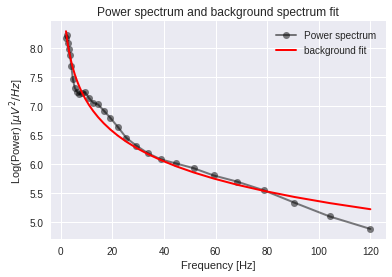

In [19]:
bosc.background_fit('list', 0)

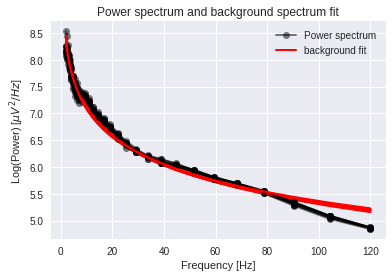

In [6]:
for i in range(10):
    bosc.background_fit('list', i)

0.983719771710839

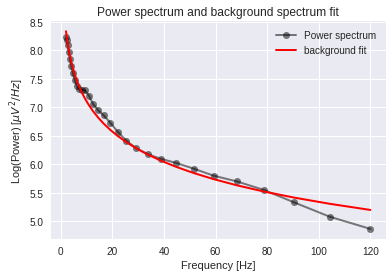

In [20]:
bosc.background_fit('session')

You can also view the EEG trace with true oscillatory periods highlighted in red. The raw_trace() method takes a frequency *index* as a required argument. You can access the available frequencies with bosc.freqs. 

In [21]:
bosc.freqs.round(2)

array([  2.  ,   2.3 ,   2.65,   3.05,   3.52,   4.05,   4.67,   5.37,
         6.19,   7.13,   8.21,   9.45,  10.88,  12.54,  14.44,  16.63,
        19.15,  22.05,  25.39,  29.24,  33.68,  38.78,  44.67,  51.44,
        59.24,  68.22,  78.57,  90.48, 104.2 , 120.  ])

In [22]:
list(bosc.freqs.round(2)).index(9.45)

11

In [11]:
bosc.detected[0][11].sum()

3995.0

In [10]:
bosc.detected[0][5].shape

(30012,)

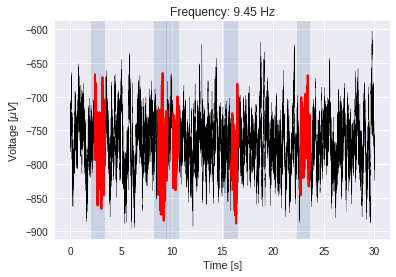

In [12]:
bosc.raw_trace(freq_idx=11, list_idx=0)

Zooming in on a region of interest is easy enough with plt.xlim(start, end)

(0, 5)

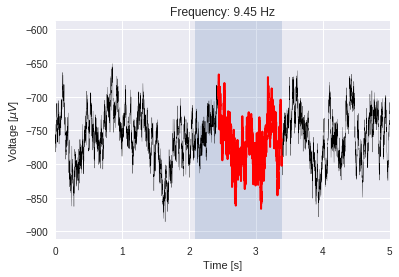

In [15]:
bosc.raw_trace(11)
plt.xlim(0, 5)

To see the signal filtered, which is a bit more intuitive, use the 'filtered' parameter

CPP total time wavelet loop:  4.763029098510742


(1, 4)

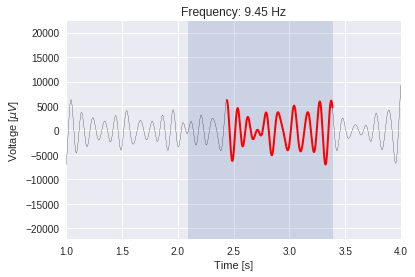

In [18]:
bosc.raw_trace(11, filtered = True)
plt.xlim(1, 4)

Now we can calculate p_episode averaged for all events of interest, for recalled events, for non-recalled events, and ttest scores comparing recalled and not-recalled

In [25]:
pep.calc_subj_pep?

Signature: pep.calc_subj_pep(subj, elecs=None, method='bip', relstart=300, relstop=1301, freq_specs=(2, 120, 30), percentthresh=0.95, numcyclesthresh=3, load_eeg=False, save_eeg=False, save_result=False, plot=False, kind='r1', experiment='FR1', eeg_path='', result_path='')
Docstring:
Inputs:
subj - subject string
elecs - list of electrode pairs (strings)
method - bip or avg depending on referencing scheme
freq_specs - tuple of (low_freq, high_freq, num_freqs) for background fitting in BOSC.

Returns:
rec - average Pepisode for recalled words at each frequency
nrec - average Pepisode for non-recalled words at each frequency
t - t-score at each frequency, comparing rec and nrec across events
** Note that tscore is not itself meaningful because events are not independent. Comparing these 
    tscores across subjects, however, is valid.
File:      ~/Theta_Project/P_episode.py
Type:      function


In [3]:
pep_all, pep_rec, pep_nrec, t = pep.calc_subj_pep(subject, ['5LD3-5LD4'], load_eeg= True, eeg_path= '/home1/jrudoler/Saved_files/bosc_referencing/'+subject+'/'+method+'/eeg/', save_eeg= False, save_result= False)

Subject:  R1195E
['5LD3-5LD4']
['5LD3', '5LD4']
Loading session 0 EEG
CPP total time wavelet loop:  5.533702850341797
0.28
(30,)
Loading session 1 EEG
CPP total time wavelet loop:  5.130569696426392
0.2733333333333333
(2, 30)
Loading session 2 EEG
CPP total time wavelet loop:  5.2937445640563965
0.30444444444444446
(3, 30)
3 sessions
900 total events: 274 recalled and 626 non-recalled


This plotting method needs work - it will not work for other users just yet, but I've included it here to get an idea of how this data can be visualized.

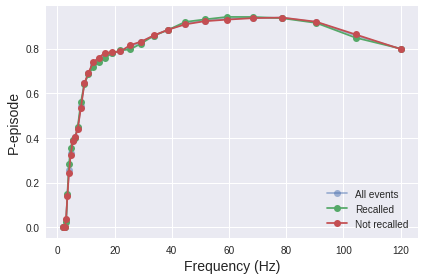

In [4]:
pep.plot_pepisode(all_pep, rec, nrec)